In [ ]:
import zipfile
path = "drive/MyDrive/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

In [ ]:
import glob
from PIL import Image
fs = glob.glob("train/*")
Image.open(fs[120]).resize((224, 224)).convert("RGB")

In [ ]:
import pandas as pd
dog = glob.glob("train/dog.*")
cat = glob.glob("train/cat.*")
datas = pd.DataFrame({
    "path":dog + cat,
    "ans":[0]* len(dog) + [1]* len(cat)
})
datas

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
# 取出每一層
vgg_layers = vgg.layers
for l in vgg_layers:
    l.trainable = False
clf_layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(vgg_layers + clf_layers)
model.summary()

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(), 
       optimizer="adam",
       metrics=["accuracy"])

In [ ]:
# demo pre: 遇處理需要與當初相同
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(fs[5000]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
preprocess_input(img_np)

In [ ]:
x, y = np.array(datas["path"]), np.array(datas["ans"])

In [ ]:
# x,y= 資料來源 / batch= 圖片讀取量
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), size=batch)
    y_batch = y[idx]
    x_batch, x_batch_ori = [], []
    for p in x[idx]:
        img = Image.open(p).resize((224, 224)).convert("RGB")
        img_np = np.array(img) 
        img_np_pre = preprocess_input(img_np)
        x_batch.append(img_np_pre)
        x_batch_ori.append(img_np)
    return (np.array(x_batch), np.array(y_batch), np.array(x_batch_ori))
x_batch, y_batch, x_batch_ori = get_data(x, y)
print(x_batch.shape)
print(y_batch.shape)
print(x_batch_ori.shape)

(20, 224, 224, 3)
(20,)
(20, 224, 224, 3)


In [ ]:
# train_on_batch, test_on_batch
for i in range(20):
  print("-" * 15 , i , "-" * 15)
  x_batch, y_batch, x_batch_ori = get_data(x, y)
  result = model.train_on_batch(x_batch, y_batch)
  print("Train:", result)
  x_batch, y_batch, x_batch_ori = get_data(x, y)
  result = model.test_on_batch(x_batch, y_batch)
  print("Test:", result)

In [ ]:
  x_batch, y_batch, x_batch_ori = get_data(x, y, 2000)
model.evaluate(x_batch, y_batch)

63/63 [==============================] - 31s 328ms/step - loss: 0.3619 - accuracy: 0.8435


[0.36187970638275146, 0.843500018119812]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


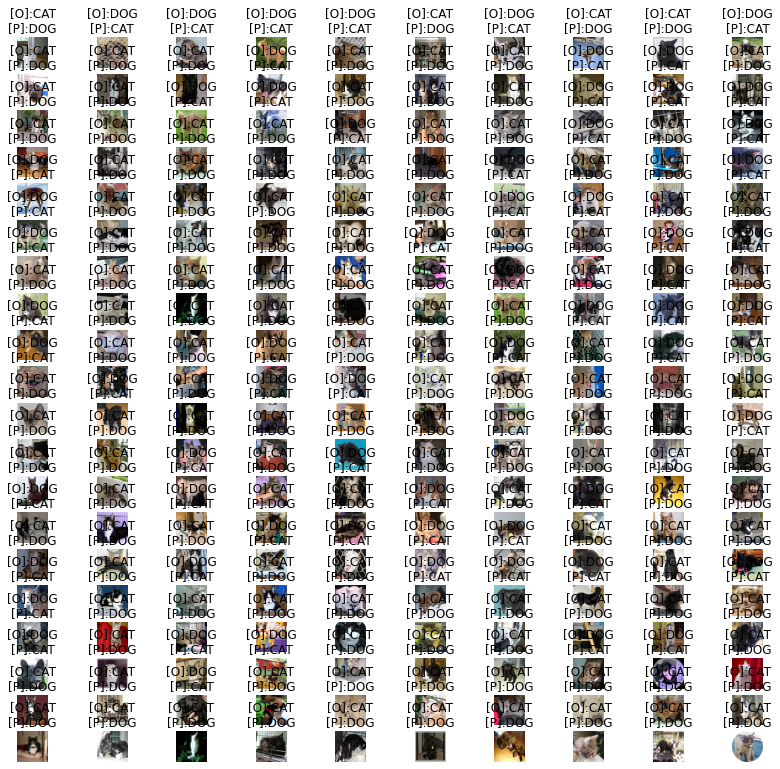

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
pre = model.predict_classes(x_batch)
trans = ["DOG", "CAT"]
idx = np.nonzero(pre != y_batch)[0][:200]
false_img = x_batch_ori[idx]
false_pre = pre[idx]
false_label = y_batch[idx]
plt.figure(figsize=(14, 14))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[false_label[i]], trans[false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(false_img[i])

In [ ]:
import requests
from PIL import Image
# RGB, RGBA, L(gray)
url = input("url:")
headers = {
  "user-agent":"user-agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36"  
}
response = requests.get(url, headers=headers, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_r = preprocess_input(img_np.reshape(1, 224, 224, 3))
proba = model.predict(img_np_r)[0]
for i, p in enumerate(proba):
    print(trans[i], "的機率:", p)
ans = model.predict_classes(img_np_r)[0]
print("答案:", trans[ans])
plt.imshow(img_np)